In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import gym
import random
import numpy as np
import tensorflow as tf
from collections import deque
from scipy.special import softmax
from tensorflow.keras import Model, layers, optimizers
import matplotlib.pyplot as plt

## **DDQN with Average advantage subtracted from advantage network output (Type 1)**

In [ ]:
# Define the Model
class QNetwork(Model):
  def __init__(self):
    super(QNetwork, self).__init__()
    # Common Feature Network
    self.fcFeat = layers.Dense(128,activation = tf.nn.relu)
    # Value layers to compute value
    self.valNet = layers.Dense(128,activation = tf.nn.relu)
    # Advantage layers to compute advantage
    self.advNet = layers.Dense(128,activation = tf.nn.relu)
    # single output - gives value of a given state
    self.valOut = layers.Dense(1)
    # 3 actions - -1, 0, or +1
    self.advOut = layers.Dense(3)

  def call(self,x):

    feat = self.fcFeat(x)
    valHid = self.valNet(feat)
    advHid = self.advNet(feat)

    val = self.valOut(valHid)
    adv = self.advOut(advHid)

    advAvg = tf.reduce_mean(adv,axis=1,keepdims=True) # Type -1
    Q = val + (adv - advAvg) # Type - 1
    return Q

  def chooseAct(self, x):

    x = x[np.newaxis,:]
    Q = self.call(x)
    act = tf.argmax(Q, axis = 1)
    act = int(np.squeeze(act))
    return act


In [ ]:
# Define memory buffer
class Memory(object):
  def __init__(self,memory_size: int) -> None:
    self.memory_size = memory_size
    self.buffer = deque(maxlen = memory_size)

  def add(self,experience) -> None:
    self.buffer.append(experience)

  def size(self):
    return len(self.buffer)

  def sample(self,batch_size: int):
    if batch_size > len(self.buffer):
      batch_size = len(self.buffer)
    indices = np.random.choice(np.arange(len(self.buffer)),size=batch_size,replace=False)
    return [self.buffer[i] for i in indices]

  def clear(self):
    self.buffer.clear()

In [ ]:
# Setting up the hyperparameters and environment
# RL parameters
gamma = 0.99
batch_size = 16
replay_memory = 50000
explore_frames = 20000
epsilon_initial = 0.1
epsilon_final = 0.0001
learning_rate = 1e-4
num_episodes = 500
max_timesteps = 500
update_target = 200
update_model = 4
memory_replay = Memory(replay_memory)
modelQ = QNetwork()
targetQ = QNetwork()
targetQ.set_weights(modelQ.get_weights())

mse = tf.keras.losses.MeanSquaredError()
optim = optimizers.Adam(learning_rate)

tf.keras.backend.set_floatx('float64')

reward_history = []
env = gym.make('Acrobot-v1')
state = env.reset()
epsilon = epsilon_initial
frame_num = 0
for episode in range(num_episodes):
  state = env.reset() # reset env after each episode
  episode_reward = 0 # reset episode reward after each episode
  for time in range(max_timesteps): # start the epsiode and run until clock runs out or until done (or reward achieved)
    prob = random.random()
    if prob < epsilon: # exploration
      action = random.randint(0,1)
    else: # exploitation
      action = modelQ.chooseAct(state)
    # action = modelQ.chooseAct(state)
    next_state,reward,done,_ = env.step(action) # sending action to environment
    episode_reward += reward # adding up the reward
    memory_replay.add((state,next_state,action,reward,done))
    if memory_replay.size() > 128:
      frame_num += 1
      if frame_num % update_model == 0:
        targetQ.set_weights(modelQ.get_weights())
      batch = memory_replay.sample(batch_size)
      batch_state, batch_next_state, batch_action, batch_reward, batch_done = zip(*batch)

      batch_state = np.asarray(batch_state)
      batch_next_state = np.asarray(batch_next_state)
      batch_action = np.asarray(batch_action)
      batch_reward = np.asarray(batch_reward)
      batch_done = np.asarray(batch_done)

      online_next_action = tf.cast(tf.argmax(modelQ(batch_next_state), axis=1), tf.int32)
      online_next_action_index = tf.stack([tf.range(tf.shape(online_next_action)[0]), online_next_action], axis=1)
      q_estimate = targetQ(batch_next_state)
      y = batch_reward + (1 - batch_done) * gamma * tf.stop_gradient(tf.gather_nd(q_estimate, online_next_action_index))

      with tf.GradientTape() as g:
        batch_action = tf.cast(batch_action, tf.int32)
        batch_action_index = tf.stack([tf.range(tf.shape(batch_action)[0]), batch_action], axis=1)
        q = modelQ(batch_state)
        loss = mse(tf.gather_nd(q, batch_action_index), y)

      grads = g.gradient(loss, modelQ.trainable_variables)
      optim.apply_gradients(zip(grads, modelQ.trainable_variables))

      if epsilon > epsilon_final:
        epsilon -= (epsilon_initial - epsilon_final) / explore_frames
      if done:
        break
      state = next_state
  print(f"Episode {episode}: Reward = {episode_reward}")
  reward_history.append(episode_reward)

In [ ]:
import pandas as pd
file_path = '/content/DDQN_type_1_run_5_Acrobot.xlsx'

pd.DataFrame(reward_history).to_excel(file_path,index=False)

## **DDQN with Maximum advantage subtracted from advantage network output (Type 2)**

In [ ]:
# Define the Model
class QNetwork(Model):
  def __init__(self):
    super(QNetwork, self).__init__()
    # Common Feature Network
    self.fcFeat = layers.Dense(256,activation = tf.nn.relu)
    # Value layers to compute value
    self.valNet = layers.Dense(256,activation = tf.nn.relu)
    # Advantage layers to compute advantage
    self.advNet = layers.Dense(256,activation = tf.nn.relu)
    # single output - gives value of a given state
    self.valOut = layers.Dense(1)
    # 3 actions - -1, 0, or +1
    self.advOut = layers.Dense(3)

  def call(self,x):
    feat = self.fcFeat(x)
    valHid = self.valNet(feat)
    advHid = self.advNet(feat)
    val = self.valOut(valHid)
    adv = self.advOut(advHid)
    advMax = tf.reduce_max(adv)
    advMax = tf.multiply(advMax,tf.ones([1,3],dtype = tf.float64))
    Q = val + (adv - advMax)
    return Q

  def chooseAct(self, x):
    x = x[np.newaxis,:]
    Q = self.call(x)
    act = tf.argmax(Q, axis = 1)
    act = int(np.squeeze(act))
    return act

In [ ]:
# Define memory buffer
class Memory(object):
  def __init__(self,memory_size: int) -> None:
    self.memory_size = memory_size
    self.buffer = deque(maxlen = memory_size)

  def add(self,experience) -> None:
    self.buffer.append(experience)

  def size(self):
    return len(self.buffer)

  def sample(self,batch_size: int):
    if batch_size > len(self.buffer):
      batch_size = len(self.buffer)
    indices = np.random.choice(np.arange(len(self.buffer)),size=batch_size,replace=False)
    return [self.buffer[i] for i in indices]

  def clear(self):
    self.buffer.clear()

In [ ]:
# Setting up the hyperparameters and environment
# RL parameters
gamma = 0.99
batch_size = 16
replay_memory = 50000
explore_frames = 20000
epsilon_initial = 0.1
epsilon_final = 0.0001
learning_rate = 1e-4
num_episodes = 500
max_timesteps = 500
update_target = 200
update_model = 4
memory_replay = Memory(replay_memory)
modelQ = QNetwork()
targetQ = QNetwork()
targetQ.set_weights(modelQ.get_weights())

env = gym.make('Acrobot-v1')
state = env.reset()

mse = tf.keras.losses.MeanSquaredError()
optim = optimizers.Adam(learning_rate)

tf.keras.backend.set_floatx('float64')

epsilon = epsilon_initial
frame_num = 0

reward_history_advmax = []

for episode in range(num_episodes):
  state = env.reset() # reset env after each episode
  episode_reward = 0 # reset episode reward after each episode
  for time in range(max_timesteps): # start the epsiode and run until clock runs out or until done (or reward achieved)
    prob = random.random()
    if prob < epsilon: # exploration
      action = random.randint(0,1)
    else: # exploitation
      action = modelQ.chooseAct(state)
    next_state,reward,done,_ = env.step(action) # sending action to environment
    episode_reward += reward # adding up the reward
    memory_replay.add((state,next_state,action,reward,done))
    if memory_replay.size() > 128:
      frame_num += 1
      if frame_num % update_model == 0:
        targetQ.set_weights(modelQ.get_weights())
      batch = memory_replay.sample(batch_size)
      batch_state, batch_next_state, batch_action, batch_reward, batch_done = zip(*batch)

      batch_state = np.asarray(batch_state)
      batch_next_state = np.asarray(batch_next_state)
      batch_action = np.asarray(batch_action)
      batch_reward = np.asarray(batch_reward)
      batch_done = np.asarray(batch_done)

      online_next_a = tf.cast(tf.argmax(modelQ(batch_next_state), axis=1), tf.int32)
      online_next_a_index = tf.stack([tf.range(tf.shape(online_next_a)[0]), online_next_a], axis=1)
      q_ = targetQ(batch_next_state)
      y = batch_reward + (1 - batch_done) * gamma * tf.stop_gradient(tf.gather_nd(q_, online_next_a_index))

      with tf.GradientTape() as g:
        batch_action = tf.cast(batch_action, tf.int32)
        batch_action_index = tf.stack([tf.range(tf.shape(batch_action)[0]), batch_action], axis=1)
        q = modelQ(batch_state)
        loss = mse(tf.gather_nd(q, batch_action_index), y)

      grads = g.gradient(loss, modelQ.trainable_variables)
      optim.apply_gradients(zip(grads, modelQ.trainable_variables))

      if epsilon > epsilon_final:
        epsilon -= (epsilon_initial - epsilon_final) / explore_frames
      if done:
        break
      state = next_state
  print(f"Episode {episode}: Reward = {episode_reward}")
  reward_history_advmax.append(episode_reward)

In [ ]:
import pandas as pd
file_path = '/content/DDQN_type_2_run_5_Acrobot.xlsx'

pd.DataFrame(reward_history_advmax).to_excel(file_path,index=False)

Text(0.5, 1.0, 'Compare DDQN with type 1 vs type 2 implementation for Acrobot Environment')

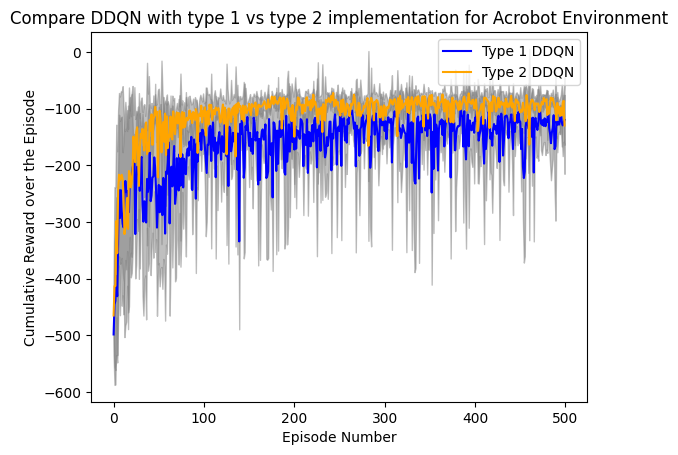

In [4]:
import pandas as pd
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

num_episodes = 500
num_runs = 5

adv_avg_scores = np.array(pd.read_excel('DDQN_type_1_Acrobot.xlsx'))
adv_max_scores = np.array(pd.read_excel('DDQN_type_2_Acrobot.xlsx'))

mean_scores_max = np.mean(adv_max_scores,axis=0)
std_scores_max = np.std(adv_max_scores,axis=0)

mean_scores_avg = np.mean(adv_avg_scores,axis=0)
std_scores_avg = np.std(adv_avg_scores,axis=0)

plt.figure()
plt.plot(np.arange(num_episodes),mean_scores_avg,color='blue',label='Type 1 DDQN')
plt.fill_between(np.arange(num_episodes), mean_scores_avg - std_scores_avg, mean_scores_avg + std_scores_avg, color='gray', alpha=0.5)
plt.plot(np.arange(num_episodes),mean_scores_max,color='orange',label='Type 2 DDQN')
plt.fill_between(np.arange(num_episodes), mean_scores_max - std_scores_max, mean_scores_max + std_scores_max, color='gray', alpha=0.5)
plt.legend()
plt.xlabel('Episode Number')
plt.ylabel('Cumulative Reward over the Episode')
plt.title('Compare DDQN with type 1 vs type 2 implementation for Acrobot Environment')

In [5]:
# For finding the means every 10 episodes
smoothened_means = np.zeros((50,2))
smoothened_stds = np.zeros((50,2))

for_mean_wout = deque(maxlen=10)
for_std_wout = deque(maxlen=10)

for_mean_w = deque(maxlen=10)
for_std_w = deque(maxlen=10)
c = 0
for i in range(500):
  for_mean_wout.append(adv_avg_scores[:,i])
  for_mean_w.append(adv_max_scores[:,i])
  if i % 10 == 0:
    smoothened_means[c,0] = np.mean(for_mean_wout)
    smoothened_means[c,1] = np.mean(for_mean_w)
    smoothened_stds[c,0] = np.std(for_mean_wout)
    smoothened_stds[c,1] = np.std(for_mean_w)
    c += 1

Text(0.5, 1.0, 'Compare DDQN with type 1 vs type 2 implementation for Acrobot Environment')

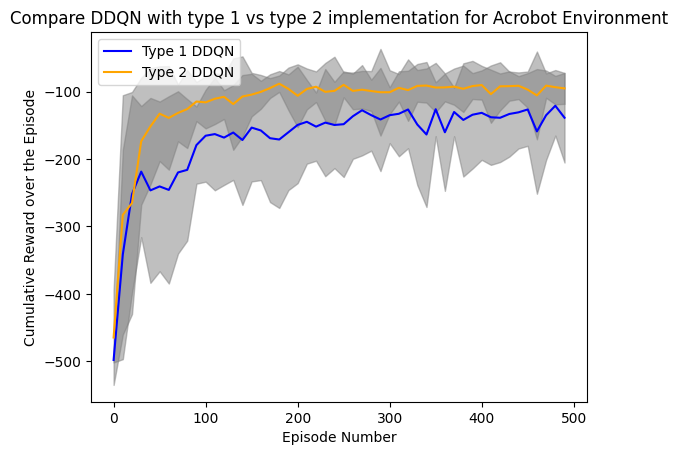

In [6]:
plt.figure()
plt.plot(np.arange(50)*10,smoothened_means[:,0],color='blue',label='Type 1 DDQN')
plt.fill_between(np.arange(50)*10, smoothened_means[:,0] - smoothened_stds[:,0], smoothened_means[:,0] + smoothened_stds[:,0], color='gray', alpha=0.5)
plt.plot(np.arange(50)*10,smoothened_means[:,1],color='orange',label='Type 2 DDQN')
plt.fill_between(np.arange(50)*10, smoothened_means[:,1] - smoothened_stds[:,1], smoothened_means[:,1] + smoothened_stds[:,1], color='gray', alpha=0.5)
plt.legend()
plt.xlabel('Episode Number')
plt.ylabel('Cumulative Reward over the Episode')
plt.title('Compare DDQN with type 1 vs type 2 implementation for Acrobot Environment')